2025-11-30 14:25:51.402 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-11-30 14:25:51.403 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-11-30 14:25:51.503 
  command:

    streamlit run /opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-11-30 14:25:51.504 No runtime found, using MemoryCacheStorageManager


Fetching full S&P 500 history...
Data range: 1935 to 2024

Calibrated AR(4):
Intercept: 0.1270
Coefficients: [-0.11511988 -0.17945057  0.02971179  0.12789895]
Volatility: 17.39%

Analyzing 2008 Financial Crisis...


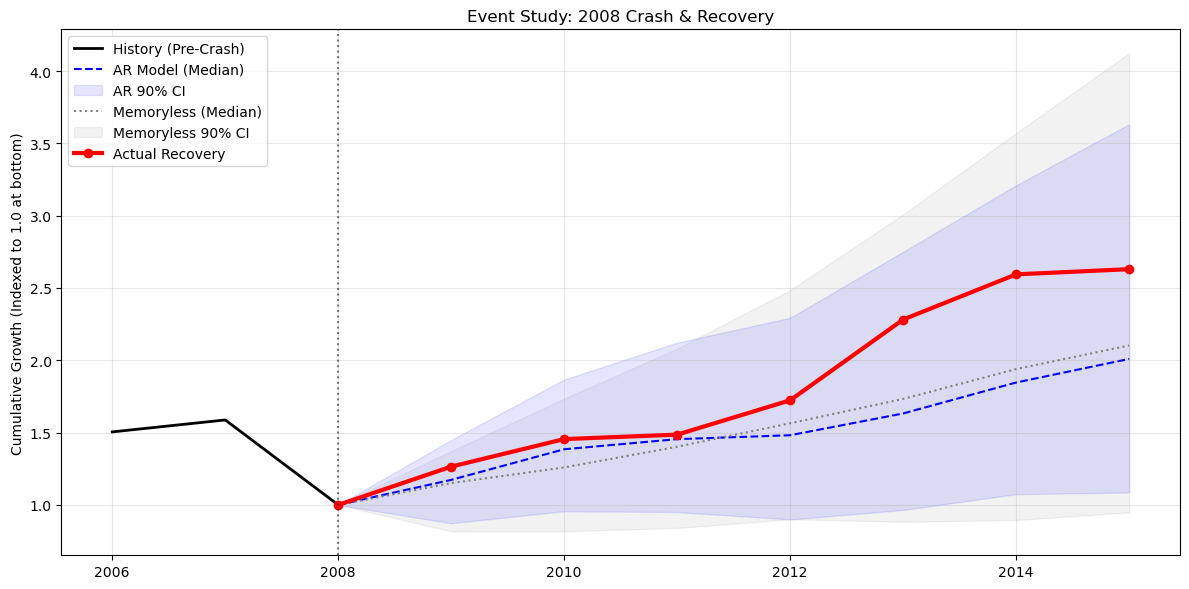


Analyzing 2000 Dot Com Bubble...


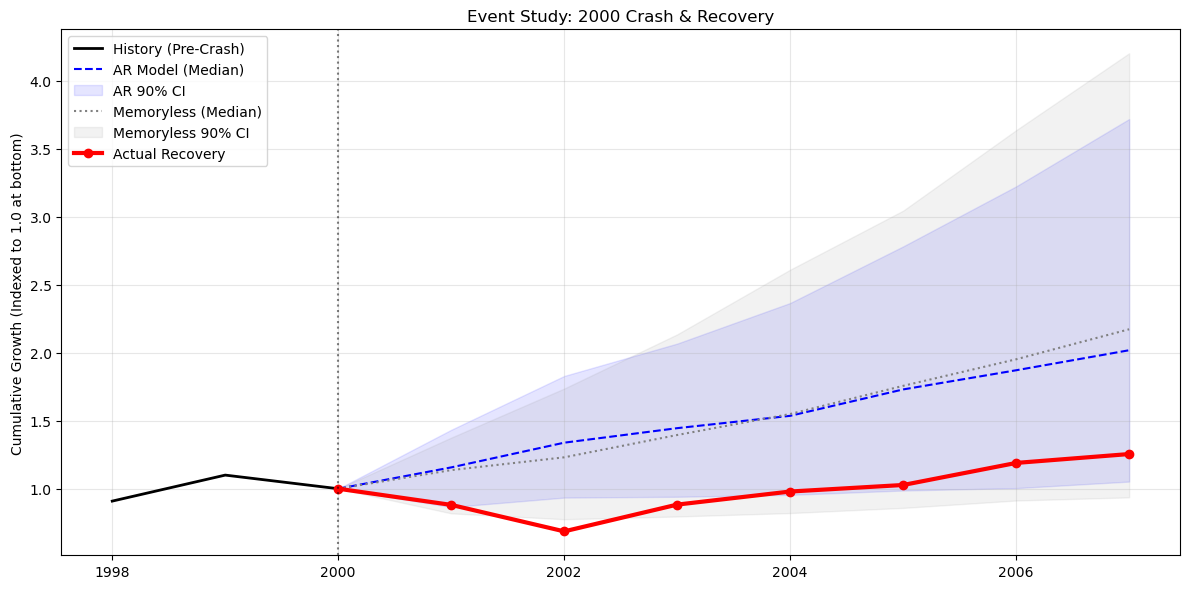


Analyzing 2022 Inflation Shock...


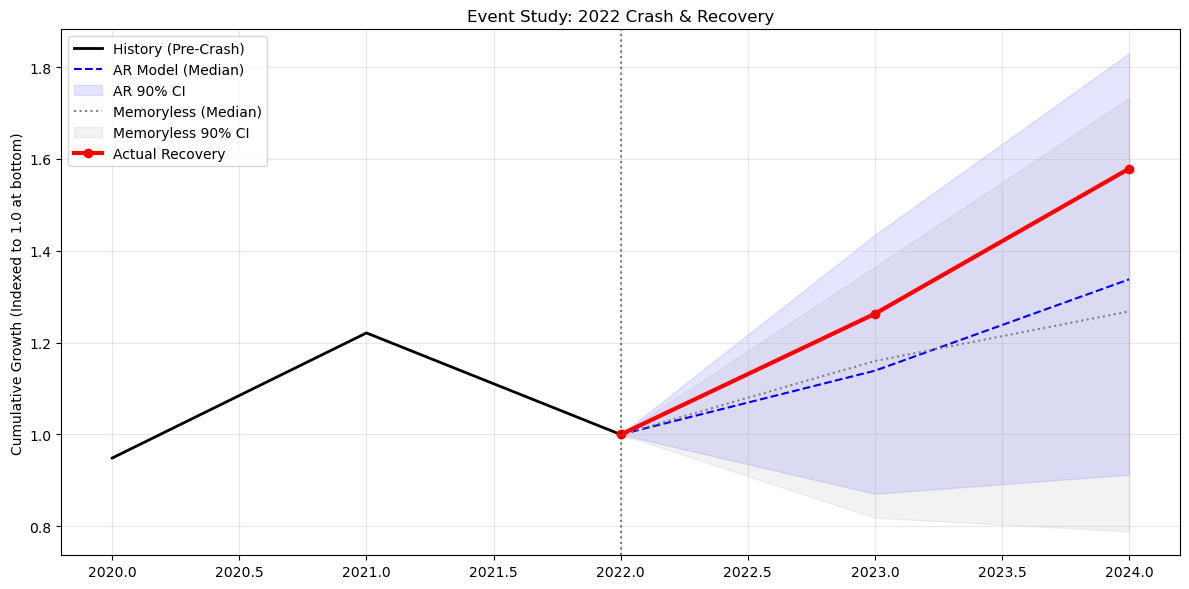


Analyzing 1974 Crash...


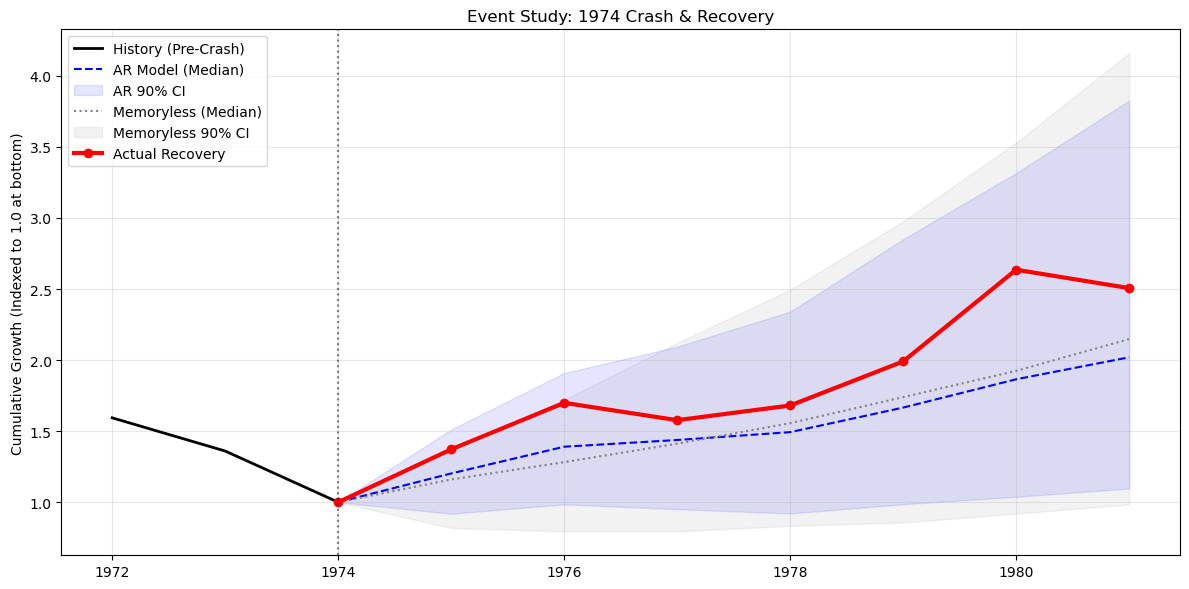

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

# Add the parent directory to the system path to import simulator
sys.path.insert(0, os.path.abspath('..'))
from simulator import MeanRevertingMarket, get_sp500_data

# ==============================================================================
# 1. GET DATA & CALIBRATE MODEL
# ==============================================================================
print("Fetching full S&P 500 history...")
sp500_returns = get_sp500_data(history_years=90) # Get max available history

# Create dates for the data (approximate, assuming annual ending today)
years = np.arange(datetime.date.today().year - len(sp500_returns), datetime.date.today().year)
df_hist = pd.DataFrame({'Year': years, 'Return': sp500_returns.ravel()})
df_hist.set_index('Year', inplace=True)

print(f"Data range: {df_hist.index.min()} to {df_hist.index.max()}")

# Calibrate AR Model on FULL history
ar_order = 4
ar_model = MeanRevertingMarket(ar_order=ar_order)
stats = ar_model.calibrate_from_history(sp500_returns)
print(f"\nCalibrated AR({ar_order}):")
print(f"Intercept: {stats['intercept']:.4f}")
print(f"Coefficients: {stats['ar_coeffs']}")
print(f"Volatility: {stats['volatility']:.2%}")

# ==============================================================================
# 2. EVENT STUDY FUNCTIONS
# ==============================================================================
def run_event_study(start_year, n_years=10, n_paths=1000, lookback_years=3):
    """
    Runs simulations starting from a specific historical year.
    Compares Actual vs AR Model vs Memoryless Model.
    Includes a lookback period to visualize the crash leading up to the start_year.
    """
    if start_year not in df_hist.index:
        print(f"Start year {start_year} not in data.")
        return
        
    start_idx = df_hist.index.get_loc(start_year)
    
    # --- 0. PRE-CRASH HISTORY (Lookback) ---
    # Years: [start - lookback, ... , start]
    pre_start_idx = max(0, start_idx - lookback_years + 1)
    pre_returns = df_hist.iloc[pre_start_idx : start_idx+1]['Return'].values
    pre_years = df_hist.index[pre_start_idx : start_idx+1]
    
    # Calculate Pre-Path: We want it to END at 1.0
    # Cumprod forward, then divide by last value
    pre_path_raw = np.cumprod(1 + pre_returns)
    pre_path = pre_path_raw / pre_path_raw[-1]
    
    # --- 1. ACTUAL FUTURE HISTORY ---
    # Years: [start, ... , start + n]
    # Note: actual_returns[0] is return of year start+1
    actual_returns = df_hist.iloc[start_idx+1 : start_idx+1+n_years]['Return'].values
    actual_path = np.insert(np.cumprod(1 + actual_returns), 0, 1.0) # Start at 1.0
    actual_years = df_hist.index[start_idx : start_idx+1+n_years]
    
    # --- 2. AR SIMULATION ---
    # Seed with returns ending at start_year
    history_window = df_hist.iloc[start_idx-ar_order+1 : start_idx+1]['Return'].values[::-1] 
    
    ar_paths = np.zeros((n_years, n_paths))
    current_windows = np.tile(history_window.reshape(1, -1), (n_paths, 1))
    
    for t in range(n_years):
        rets = ar_model.simulate_year(current_windows, simulations=n_paths)
        ar_paths[t, :] = rets
        current_windows = np.roll(current_windows, shift=1, axis=1)
        current_windows[:, 0] = rets
        
    ar_cum_paths = np.vstack([np.ones(n_paths), np.cumprod(1 + ar_paths, axis=0)])
    
    # --- 3. MEMORYLESS SIMULATION ---
    mu = np.mean(sp500_returns)
    residuals = (sp500_returns - mu).ravel()
    
    mem_paths = np.zeros((n_years, n_paths))
    for t in range(n_years):
        rets = mu + np.random.choice(residuals, n_paths)
        mem_paths[t, :] = rets
        
    mem_cum_paths = np.vstack([np.ones(n_paths), np.cumprod(1 + mem_paths, axis=0)])
    
    # ================= PLOTTING ================ 
    plt.figure(figsize=(12, 6))
    
    # Plot Lookback
    plt.plot(pre_years, pre_path, color='black', linewidth=2, linestyle='-', label='History (Pre-Crash)')
    
    # Plot AR Cone
    ar_median = np.median(ar_cum_paths, axis=1)
    ar_low = np.percentile(ar_cum_paths, 5, axis=1)
    ar_high = np.percentile(ar_cum_paths, 95, axis=1)
    
    plt.plot(actual_years, ar_median, color='blue', linestyle='--', label='AR Model (Median)')
    plt.fill_between(actual_years, ar_low, ar_high, color='blue', alpha=0.1, label='AR 90% CI')
    
    # Plot Memoryless Cone
    mem_median = np.median(mem_cum_paths, axis=1)
    mem_low = np.percentile(mem_cum_paths, 5, axis=1)
    mem_high = np.percentile(mem_cum_paths, 95, axis=1)
    
    plt.plot(actual_years, mem_median, color='gray', linestyle=':', label='Memoryless (Median)')
    plt.fill_between(actual_years, mem_low, mem_high, color='gray', alpha=0.1, label='Memoryless 90% CI')
    
    # Plot Actual Future
    plt.plot(actual_years, actual_path, color='red', linewidth=3, marker='o', label='Actual Recovery')
    
    # Add vertical line at start year
    plt.axvline(x=start_year, color='black', linestyle=':', alpha=0.5)
    
    plt.title(f"Event Study: {start_year} Crash & Recovery")
    plt.ylabel("Cumulative Growth (Indexed to 1.0 at bottom)")
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ==============================================================================
# 3. RUN ANALYSIS ON MAJOR CRASHES
# ==============================================================================

# 2008 Financial Crisis
print("\nAnalyzing 2008 Financial Crisis...")
run_event_study(start_year=2008, n_years=7)

# 2000 Dot Com Bubble
print("\nAnalyzing 2000 Dot Com Bubble...")
run_event_study(start_year=2000, n_years=7)

# 2022 Inflation Shock (Short history)
print("\nAnalyzing 2022 Inflation Shock...")
run_event_study(start_year=2022, n_years=2)

# 1974 Crash
print("\nAnalyzing 1974 Crash...")
run_event_study(start_year=1974, n_years=7)


In [3]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

# Add the parent directory to the system path to import simulator
sys.path.insert(0, os.path.abspath('..'))
from simulator import MeanRevertingMarket, get_sp500_data

print("Fetching full S&P 500 history...")
sp500_returns = get_sp500_data(history_years=90) # Get max available history

# Create dates for the data (approximate, assuming annual ending today)
years = np.arange(datetime.date.today().year - len(sp500_returns), datetime.date.today().year)
df_hist = pd.DataFrame({'Year': years, 'Return': sp500_returns.ravel()})
df_hist.set_index('Year', inplace=True)

print(f"Data range: {df_hist.index.min()} to {df_hist.index.max()}")

# Calibrate AR Model on FULL history
ar_order = 4
ar_model = MeanRevertingMarket(ar_order=ar_order)
self = ar_model

Fetching full S&P 500 history...
Data range: 1935 to 2024


In [11]:
start_window = self.history_window

In [12]:
start_window

array([ 0.16448841,  0.23309002,  0.24230501, -0.19442827])

In [6]:
self.calibrate_from_history(sp500_returns)

{'ar_coeffs': array([-0.13429807, -0.12327906, -0.00294468,  0.15825661]),
 'intercept': 0.0857948773988299,
 'mean_return': 0.07783505958969883,
 'volatility': 0.16531547638513044}

In [7]:
market_return = self.simulate_year(current_history_windows, simulations=n_paths)

In [10]:
years

array([1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,
       2023, 2024])

In [20]:
market_matrix = np.zeros((30, n_paths))

In [23]:
current_history_windows.shape

(5000, 4)

In [24]:
market_return = self.simulate_year(current_history_windows, simulations=n_paths)

In [27]:
market_matrix[0, :] = market_return

In [28]:
market_matrix

array([[ 0.20593287,  0.15406454,  0.0120434 , ..., -0.08913605,
        -0.00388838,  0.42102577],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [29]:
current_history_windows = np.roll(current_history_windows, shift=1, axis=1)

In [30]:
current_history_windows.shape

(5000, 4)

In [31]:
current_history_windows[:, 0] = market_return

In [35]:
current_history_windows.shape

(5000, 4)

In [34]:
np.dot(current_history_windows, self.ar_coeffs).shape

(5000,)

In [36]:
market_return = self.simulate_year(current_history_windows)

In [37]:
market_matrix[1, :] = market_return

In [38]:
current_history_windows = np.roll(current_history_windows, shift=1, axis=1)

In [41]:
current_history_windows[:, 0] = market_return

In [42]:
current_history_windows

array([[ 0.08469403,  0.20593287,  0.        ,  0.        ],
       [ 0.09165984,  0.15406454,  0.        ,  0.        ],
       [ 0.11073301,  0.0120434 ,  0.        ,  0.        ],
       ...,
       [ 0.12432121, -0.08913605,  0.        ,  0.        ],
       [ 0.11287262, -0.00388838,  0.        ,  0.        ],
       [ 0.05580746,  0.42102577,  0.        ,  0.        ]])

In [17]:
ticker = "SPY"
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=50 * 365)

data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)

In [18]:
data

Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
1993-01-29,24.313032,24.330324,24.209278,24.330324,1003200
1993-02-01,24.485966,24.485966,24.330335,24.330335,480500
1993-02-02,24.537851,24.555144,24.416805,24.468682,201300
1993-02-03,24.797224,24.814516,24.555131,24.572424,529400
1993-02-04,24.900967,24.952844,24.606997,24.883674,531500
...,...,...,...,...,...
2025-11-21,659.030029,664.549988,650.849976,655.049988,123956200
2025-11-24,668.729980,670.059998,661.590027,662.690002,80437900
